# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [34]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [35]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [36]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-31 09:00:00+09:00,51629.800781,51894.101562,51613.031250,51894.101562,0,0.0,0.0
2025-10-31 09:15:00+09:00,51873.871094,52265.398438,51838.839844,52229.488281,0,0.0,0.0
2025-10-31 09:30:00+09:00,52217.628906,52257.500000,52145.738281,52193.210938,0,0.0,0.0
2025-10-31 09:45:00+09:00,52191.949219,52391.449219,52174.878906,52174.878906,0,0.0,0.0
2025-10-31 10:00:00+09:00,52175.171875,52225.460938,51983.058594,52071.699219,0,0.0,0.0
2025-10-31 10:15:00+09:00,52061.859375,52092.429688,51915.578125,52025.718750,0,0.0,0.0
2025-10-31 10:30:00+09:00,52023.921875,52093.539062,51737.281250,51737.281250,0,0.0,0.0
2025-10-31 10:45:00+09:00,51752.718750,51958.511719,51695.578125,51949.511719,0,0.0,0.0
2025-10-31 11:00:00+09:00,51946.828125,51996.140625,51835.500000,51996.140625,0,0.0,0.0


## 前日終値の取得

In [37]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-24 00:00:00+09:00    49299.648438
2025-10-27 00:00:00+09:00    50512.320312
2025-10-28 00:00:00+09:00    50219.179688
2025-10-29 00:00:00+09:00    51307.648438
2025-10-30 00:00:00+09:00    51325.609375
2025-10-31 00:00:00+09:00    52203.648438
Name: Close, dtype: float64


Date
2025-10-30 00:00:00+09:00    51325.609375
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [38]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+304.19


## ローソク足チャート（小さいサイズ）

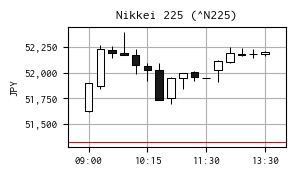

In [39]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [40]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [41]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-30 09:00:00+09:00,152.718994,152.945999,152.682007,152.722000,0,0.0,0.0
2025-10-30 09:15:00+09:00,152.716995,152.744003,152.498001,152.511993,0,0.0,0.0
2025-10-30 09:30:00+09:00,152.514008,152.718002,152.511993,152.604004,0,0.0,0.0
2025-10-30 09:45:00+09:00,152.602997,152.742996,152.518005,152.626999,0,0.0,0.0
2025-10-30 10:00:00+09:00,152.626999,152.679001,152.462997,152.580994,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-31 12:45:00+09:00,153.985992,154.067993,153.973999,154.035004,0,0.0,0.0
2025-10-31 13:00:00+09:00,154.031998,154.057007,153.899994,153.925995,0,0.0,0.0
2025-10-31 13:15:00+09:00,153.925995,154.026001,153.917007,153.951996,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [42]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-31 09:00:00+09:00,335.445770,337.162968,335.336816,337.162968
2025-10-31 09:15:00+09:00,336.950522,339.493716,336.722973,339.260459
2025-10-31 09:30:00+09:00,339.339922,339.599027,338.872736,339.181240
2025-10-31 09:45:00+09:00,339.144389,340.440744,339.033465,339.033465
2025-10-31 10:00:00+09:00,339.330842,339.657906,338.081398,338.657889
2025-10-31 10:15:00+09:00,338.726066,338.924963,337.774328,338.490927
2025-10-31 10:30:00+09:00,338.573957,339.027028,336.708487,336.708487
2025-10-31 10:45:00+09:00,336.427993,337.765788,336.056540,337.707281
2025-10-31 11:00:00+09:00,337.742534,338.063149,337.018712,338.063149


### 前日の終値のドル円レートから、前日の終値のドル換算

In [43]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-30 15:15:00+09:00


np.float64(153.04400634765625)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 335.36504042117303


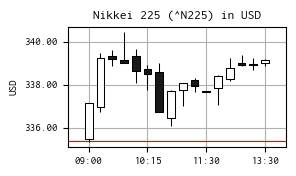

In [44]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()